# L6: Uczenie maszynowe II

## Dostosowywanie parametrów

Praktycznie każdy z algorytmów uczenia maszynowego posiada pewne parametry (lub hiper-parametry), które wpływają na proces uczenia. W przypadku użytego algorytmu SVM są to np. rodzaj funkcji jądra i stopień regularyzacji. 

Odpowiednie dostosowanie parametrów algorytmu do danego problemu może znacząco poprawić jakość jego działania. 

Sklearn posiada zaimplementowanych kilka strategii poszukiwania najlepszych parametrów. Użyjemy tutaj najprostszego podejścia losowego:

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC

x, y = load_wine(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=13
)

pipeline_classifier = make_pipeline(
    StandardScaler(), VarianceThreshold(threshold=(0.8 * (1 - 0.8))), SVC()
)

pipeline_classifier.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.15999999999999998)),
                ('svc', SVC())])

In [2]:
param_distributions = {
    "svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "svc__C": [0.1, 0.5, 1, 2, 4],
}

# now create a searchCV object and fit it to the data
search = RandomizedSearchCV(
    estimator=pipeline_classifier, n_iter=5, param_distributions=param_distributions
)
search.fit(x, y)

print(search.best_params_)

{'svc__kernel': 'rbf', 'svc__C': 1}


Mechanizm wykonuje ilosc powtórzeń zadaną przez argument `n_iter` i losuje za każdym razem wartości parametrów spośród podanych. Dla każdego z nich wykonuje cross-walidację. Możemy też przeanalizować dokładne wyniki tego procesu:

In [3]:
search.cv_results_

{'mean_fit_time': array([0.00155301, 0.00181336, 0.00147095, 0.0010963 , 0.00119772]),
 'std_fit_time': array([4.01425452e-04, 9.78616235e-05, 3.05256408e-04, 3.40754786e-05,
        3.26661645e-05]),
 'mean_score_time': array([0.00048466, 0.00066261, 0.00049548, 0.00038838, 0.00042405]),
 'std_score_time': array([3.74766099e-05, 1.15600650e-04, 8.89407272e-05, 1.04839131e-05,
        4.12016002e-06]),
 'param_svc__kernel': masked_array(data=['poly', 'sigmoid', 'rbf', 'linear', 'sigmoid'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_svc__C': masked_array(data=[4, 0.1, 1, 1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svc__kernel': 'poly', 'svc__C': 4},
  {'svc__kernel': 'sigmoid', 'svc__C': 0.1},
  {'svc__kernel': 'rbf', 'svc__C': 1},
  {'svc__kernel': 'linear', 'svc__C': 1},
  {'svc__kernel': 'sigmoid', 'svc__C': 1}],
 'split0_test_s

Parametry modelu sprawdzić możemy przy pomocy metody `get_params()` lub [w dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [4]:
pipeline_classifier.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('variancethreshold', VarianceThreshold(threshold=0.15999999999999998)),
  ('svc', SVC())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'variancethreshold': VarianceThreshold(threshold=0.15999999999999998),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'variancethreshold__threshold': 0.15999999999999998,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

```{seealso}
Istnieje szeroki wachlarz metod do selekcji parametrów modelu, poza tymi zaimplementowanymi w sklearnie. Warto przypatrzeć się [Hyperopt](https://github.com/hyperopt/hyperopt), [HpBandSter](https://github.com/automl/HpBandSter) lub [Optuna](https://optuna.org/).
```

<br/><br/><br/><br/><br/> 
## Zaawansowane przetwarzanie tekstów

### Spacy

Do przetwarzania tekstów wykorzystamy bibliotekę `spacy`. `Spacy` to darmowa biblioteka o otwartych źródłach dedykowana do pracy z tekstem. Może być wykorzystana zarówno do budowy systemów ekstrakcji informacji, jak i systemów do rozumienia języka naturalnego. Ponadto zawiera zestaw narzędzi do wstępnego przetwarzania tekstów. Spacy udostępnia wsparcie dla ponad 60 języków. 

Moduł spacy udostępnia kilka wcześniej przeuczonych potoków przetwarzania dla języka angielskiego. Ich szczegółowy opis znajduje się pod adresem [LINK](https://spacy.io/models/en). Do dalszego przetwarzania wykorzystamy potok `en_core_web_md`.

#### Instalacja i pobieranie modułów

```bash
pip install spacy
python -m spacy download en_core_web_sm
```

Potok `en_core_web_sm` zawiera takie komponenty jak:  
- [tok2vec](https://spacy.io/api/tok2vec) - Transformacja tokenów w wektory
- [tagger](https://spacy.io/api/tagger) - Tagowanie części mowy
- [parser](https://spacy.io/api/dependencyparser) - Parser zależnościowy
- [senter](https://spacy.io/api/sentencerecognizer) - Rozpoznawanie zdań
- [ner](https://spacy.io/api/entityrecognizer) - Rozpoznawanie nazw własnych
- [attribute_ruler](https://spacy.io/api/attributeruler) - Przypisywanie atrybutów do tokenów
- [lemmatizer](https://spacy.io/api/entityrecognizer) - Sprowadzanie tokenów do nazw własnych



#### Wczytanie potoków

Podstawowym obiektem jest [Language](https://spacy.io/api/language). `Language` zawiera m.in. takie elementy jak: Słownik (`vocab`), elementy Potoku przetwrzania np. `tagger`, dane specyficzne dla danego języka takie jak np. stop-słowa (ang. stopwords) czy reguły interpunkcji (ang. punctuation). Obiekt `Language` jest również tworzony podczas ładowania wcześniej przeuczonych potoków przetwrzania za pomocą `spacy.load`. Często definiuje się go pod nazwą `nlp`.

Pobrany moduł wczytujemy z wykorzystaniem wspomnianej funkcji `spacy.load`. Domyślnie wczytuje on wszystkie zdefiniowane komponenty, ale możemy go ograniczyć. Do dalszego przetwarzania wystarczą nam komponenty `tagger`, `tok2vec`, `parser`,  `lemmatizer` i `attribute_ruler`. Pozostałe możemy wykluczyć za pomocą argumentu `exclude`.

In [5]:
import spacy

nlp = spacy.load("en_core_web_md", exclude=["ner", "senter"])

Następnym kluczowym element jest obiekt [Doc](https://spacy.io/api/doc), który jest sekwencją [Tokenów](https://spacy.io/api/token). `Token` może oznaczać słowo, znak interpukcyjny itp. Obiekt `Doc` ten jest często tworzony za pomocą wywołania funkcji `__call__` obiektu `nlp`, który od razu wykonuje zdefiniowany potok przetwarzania.

In [6]:
doc = nlp("Please stop, don't parse me")

Aby dostać się do wyników przetwarzania odwołujemy się do każdego tokenu z osobna.
W naszym potoku mieliśmy zdefiniowane komponenty jak części mowy, parser zależnościowy i lemmatyzację. Aby się do nich dostać odwołamy się kolejne do atrybutów `pos_`, `dep_` i `lemma_`.

In [7]:
token = doc[0]
print(token.text, token.pos_, token.dep_, token.lemma_)

Please INTJ intj please


Wyświetlmy teraz wyniki przetwarzania dla całego tekstu.

In [8]:
for token in doc:
    print(token.text, token.pos_, token.dep_, token.lemma_)

Please INTJ intj please
stop VERB parataxis stop
, PUNCT punct ,
do AUX aux do
n't PART neg not
parse VERB ROOT parse
me PRON dobj I


<br/> <br/> 
###  Wektoryzacja tekstów za pomocą modelu TF-IDF

TF-IDF jest to skrót od ang. Term Frequency – Inverse Document Frequency.  Pierwszą składową modelu jest Term Frequency (TF),  drugim komponentem jest Inverse Document Frequency (odwrotna częstość dokumentów). Możemy zastosować różne metody ważenia dla obu komponentów, jednak w ramach tego zadania wykorzystamy jedynie proste składowe bez dodatkowego ważenia. Składowa TF jest częstością występowania wyrazów, co tak naprawdę jest wyjściem z modelu BoW. Odwrotna częstość dokumentów (IDF) jest obliczana z poniższego wzoru: 

$$
idf(w) = \log{\frac{\text{liczba dokumentow}}{\text{liczba dokumentow zawierajaca slowo w}}}
$$

 
TF-IDF jest iloczynem tych dwóch komponentów co daje finalną postać:   


$$
tfidf(w) = tf(w) * idf(w)
$$

Reprezentacja słów dla dokumentów `D1`i `D2` ` z wykorzystaniem modelu BoW po zastosowaniu dodatkowego ważenia TF-IDF została przedstawiona w poniższej tabeli.

```
D1: Problemem metody tfidf nie jest czas obliczeń.
D2: Problem w tfidf leży w wymiarowości.
```

| w          | TF(w)  | IDF(w) | TFIDF(w)  |
|------------|--------|--------|-----------|
| Problemem  | 1      | 0.69   | 0.69      |
| metody     | 1      | 0.69   | 0.69      |
| tfidf      | 2      | 0      | 0         |
| nie        | 1      | 0.69   | 0.69      |
| jest       | 1      | 0.69   | 0.69      |
| czas       | 1      | 0.69   | 0.69      |
| obliczeń   | 1      | 0.69   | 0.69      |
| Problem    | 1      | 0.69   | 0.69      |
| w          | 2      | 0.69   | 1.38      |
| leży       | 1      | 0.69   | 0.69      |
| wymiarowości | 1    | 0.69   | 0.69      |

**Tabela. Reprezentacja słów po zastosowaniu ważenia TF-IDF**
 
W rezultacie stosując otrzymaną reprezentację słów wektory cech dokumentów **D1**,**D2**, będą miały następującą postać:   
`D1 = [0.69, 0.69, 0,   0.69,  0.69, 0.69, 0.69, 0,    0,    0,    0   ]`  
`D2 = [0,    0,    0,   0,     0,    0,    0,    0.69, 1.38, 0.69, 0.69]`    

**Kolumny w wektorach cech** oznaczają reprezentacje poszczególnych wyrazów zgodnie ze słownikiem utworzonym wcześniej czyli: `'Problemem', 'metody', 'tfidf', 'nie', 'jest', 'czas', 'obliczeń', 'Problem', 'w', 'leży' 'wymiarowości'`
 
``` {important}
Reprezentację słów tworzymy tylko podczas fazy uczenia wykorzystując zbiór uczący. Podczas fazy testowania wykorzystujemy reprezentację obliczoną wcześniej przekształcając dokumenty ze zbioru testowego. Jeżeli zdarzy się taka sytuacja, że słowo ze zbioru testowego nie znajduje się w słowniku to w takim przypadku jest ono pomijane.
```


``` {hint}
Do obliczenia reprezentacji TF-IDF można wykorzystać moduł [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
```


``` {important} 
Formuła liczenia TF-DF z pakietu `sklearn.feature_extraction.text.TfidfVectorizer` jest inna niż, w przedstawionym wzorze. Szczegóły znajdują się w dokumentacji [LINK](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).
```

<br/><br/>
### Wektoryzacja tekstu za pomocą statycznych embeddingów

Poznane dotychczas metody BoW i TF-IDF pozwalały wektoryzować teksty, jednak tworzone wektory pozostawiały wiele do życzenia. 

W roku 2013 powstała rewolucyjna metoda tworzenia word-embeddingów - Word2Vec. Pozwoliła ona na tworzenie wektorów, które cechują się ciągłością w przestrzeni wektorowej - tj. słowa występujące w podobnych kontekstach będą miały wektory o zbliżonych wartościach. 





In [9]:
print(nlp("breakfast").vector.size)
print(nlp("breakfast").vector[:10])

300
[-0.6866  -1.7267  -3.0013  -1.1101   1.8389  -3.0766  -0.23369  1.0133
 -2.0234   3.0337 ]


In [10]:
nlp("breakfast").similarity(nlp("universe"))

0.08428282393175214

In [11]:
nlp("oranges").similarity(nlp("apples"))

0.5736394993414768

In [12]:
doc1 = nlp("I like oranges that are sweet.")
doc2 = nlp("I like apples that are sour.")
doc1.similarity(doc2)

0.9778969482959918

Najpopularniejszym udoskonaleniem Word2Vec są metody GloVe i FastText.

GloVe dodatkowo uwzględnia częstości występowania poszczególnych słów w korpusie. Dzięki temu podobieństwo wektorów uwzględnia prawdopodobieństwo na współwystępowanie słów w podobnych kontekstach

FastText tworząc wektory dla słów, operuje na znakach. Dzięki temu także słowa spoza korpusu użytego do treningu embeddingu (tzw. OOV - out of vocabulary) mają jakiś w miarę sensowny wektor

```{seealso}
Więcej info o technikach statycznych, z przykładami i technikami działania np. [tutaj](https://neptune.ai/blog/vectorization-techniques-in-nlp-guide)
```

<br/><br/>
### Wektoryzacja tekstu za pomocą embeddingów kontekstowych

Największą wadą modeli statycznych jest ich bezkontekstowość - dane słowo ma zawsze taki sam wektor, niezależnie od jego użycia i znaczenia (np. zamek).

Współcześnie używane metody embeddowania tekstu bazują głównie na modelach językowych (_language modelling_), opartych na architekturze Transformerów. Stworzony w roku 2019 model BERT spowodował rewolucję w dziedzinie NLP, deklasując poprzednie metody wektoryzacji często o rząd wielkości.

Embeddingi uzyskiwane dzięki BERTowi i jego pochodnym cechują się kontekstowością, ponadto uwzględniana jest też pozycja słowa w zdaniu. BERT lepiej niz FastText radzi sobie też z OOV, dzięki operowaniu na tzw. _word pieces_.


Istnieje mnogość modeli, zgromadzonych głównie wokół repozytorium [HuggingFace](https://huggingface.co/). Dla języka polskiego najpopularniejszym modelem jest [HerBERT](https://huggingface.co/allegro/herbert-base-cased), istnieje również wiele modeli wielojęzykowych, np. [LABSE](https://huggingface.co/sentence-transformers/LaBSE). 


<br/><br/><br/><br/><br/>
## Interpretacja modeli z wykorzystaniem biblioteki SHAP

`SHAP` (SHapley Additive exPlanations) jest podejściem opartym na teorii gier, służącym do interpretacji wyników dowolnego modelu uczenia maszynowego. Szczegóły dotyczące implementacji można znaleźć w oryginalnym artykule autorów [LINK](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf). Istotność danej cechy jest wyrażone w postaci metryki `Shap Value`.

Shap wspiera modele oparte o drzewa decyzyjne, sieci neuronowe oraz obsługuje też inne metody nie wpadające w te dwie grupy kosztem czasu obliczeń.

Dostępne obecnie moduły:
- Drzewa decyzyjne - `TreeExplainer`
- Sieci Neuronowe - `DeepExplainer`, `GradientExplainer`
- Inne modele `LinearExplainer`, `KernelExplainer` (wolniejsze od innych podejść)

W ramach tego laboratorium skupimy się na wyjaśnianiu podejść bazujących o drzewa decyzyjnie, a konkretnie o algorytm [XGBoost](https://github.com/dmlc/xgboost).

### Instalacja

Zacznijmy od instalacji potrzebnych bibliotek

```
pip install shap
pip install xgboost==1.3.3
```

Następnym krokiem jest wyuczenie modelu XGBooost, do analizy wykorzystamy wcześniej poznany zbiór `Boston House Pricing`. Wykorzystamy loader dostarczony przez bibliotekę shap. Przypomnijmy najpierw co oznaczają dane cechy w tym zbiorze danych. 

| Atrybut | Opis 
| --- | --- |
| CRIM |  wskaźnik przestępczości na jednego mieszkańca w poszczególnych miastach|
| ZN | udział terenów mieszkaniowych przeznaczonych pod działki powyżej 25.000 mkw. |
| INDUS | udział powierzchni pod działalność niedetaliczną w poszczególnych miastach |
| CHAS | cecha przyjmuje wartość 1, jeżeli obszar przecina rzekę Charlser, 0 w innym wypadku |
| NOX | stężenie tlenków azotu (części na 10 milionów) |
| RM | średnia liczba pokoi w mieszkaniu |
| AGE | odsetek jednostek okupowanych przez właścicieli zbudowanych przed 1940 rokiem |
| DIS | odległości ważone do pięciu ośrodków zatrudnienia w Bostonie | 
| RAD | wskaźnik dostępności do autostrad prowadzących do centrum miasta | 
| TAX | pełnowartościowa stawka podatku od nieruchomości na 10000 USD | 
| PTRATIO | stosunek liczby uczniów do liczby nauczycieli w poszczególnych miastach | 
| B       | 1000 (Bk - 0,63) ^ 2 gdzie Bk to odsetek Afroamerykanów w mieście |
| LSTAT | % niższy status populacji |
| Cecha wyjściowa (MEDVAL) | mediana wartości domów zamieszkanych przez właścicieli w tys. dolarów |


In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

In [14]:
import xgboost
import shap

x, y = shap.datasets.california()
model = xgboost.XGBRegressor().fit(x, y)

Przeliczmy teraz wpływ cech na predykcję

In [15]:
shap.initjs()  # Inicjalizacja obsługi wizualizacji opartych na JavaScript w notebooku
explainer = shap.TreeExplainer(model)  # Inicjalizacja modułu dla konkretnego modelu
shap_values = explainer(x)# Obliczenie wartości shap

Shap umożliwia analizę wyników per daną próbką, lub w podsumowaniu. Zacznijmy od przedstawienia analiz per próbka danych

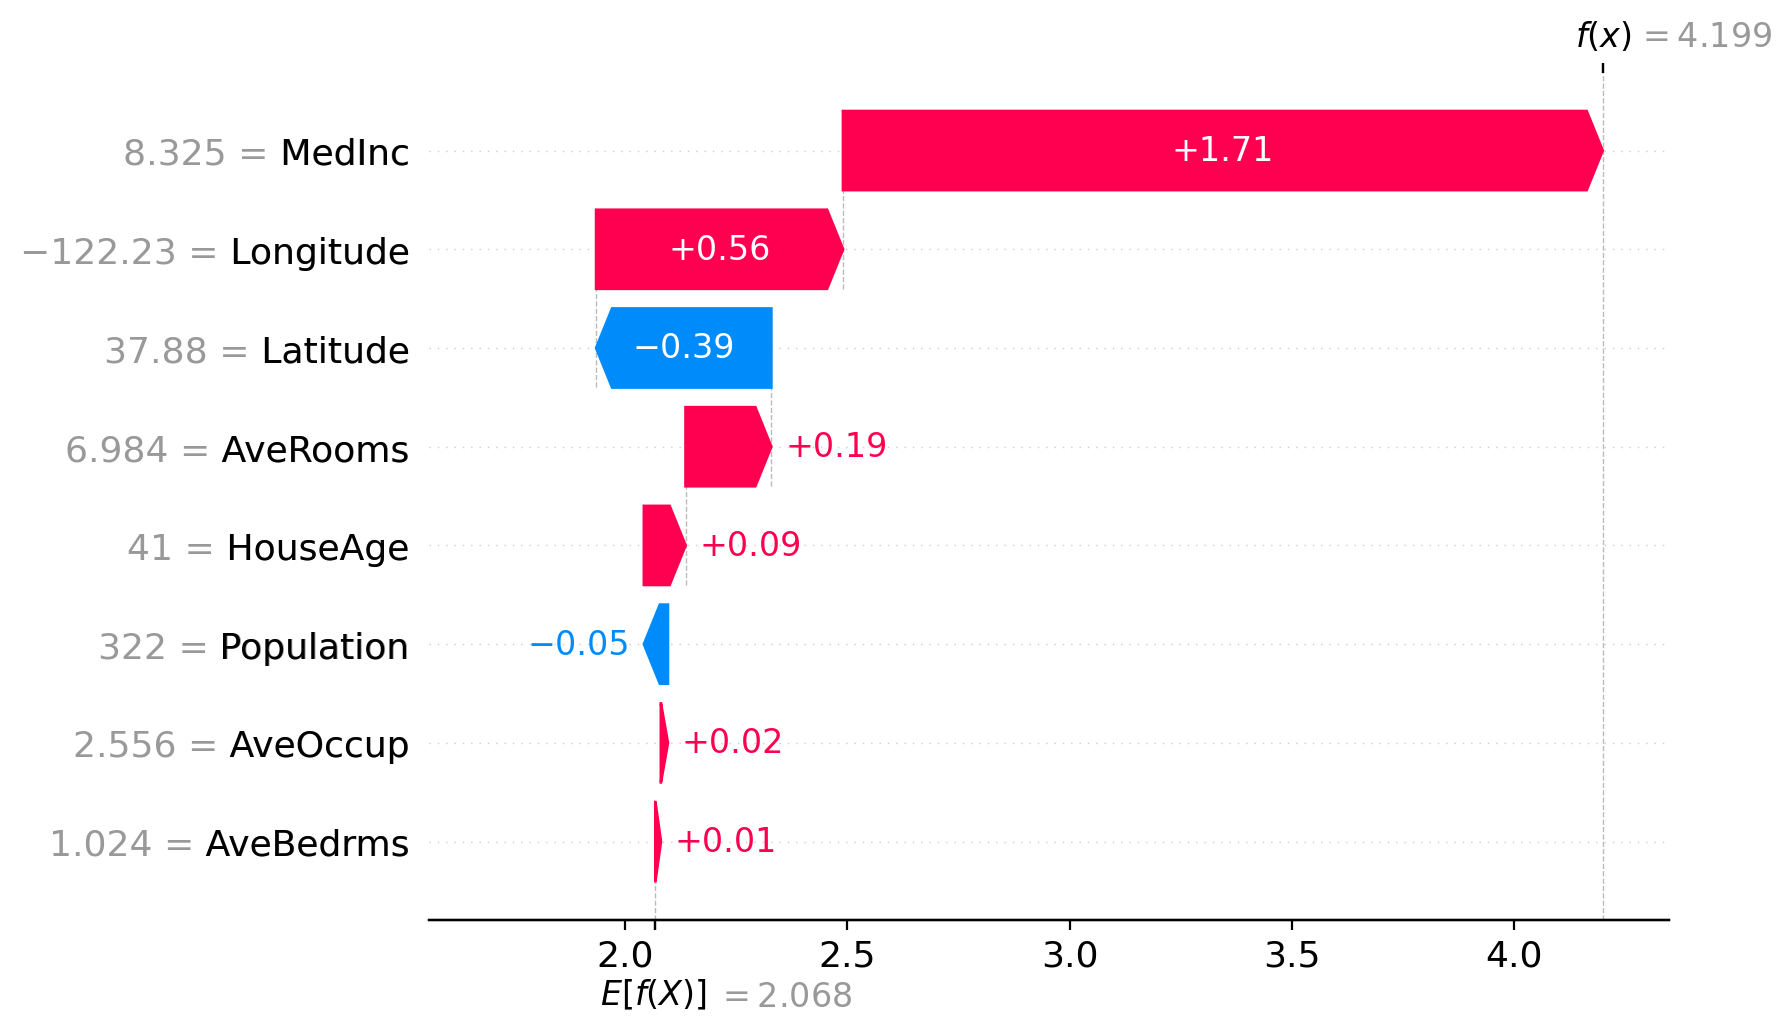

In [16]:
shap.plots.waterfall(shap_values[0])

Wartości zaznaczono na czerwono oznaczają cechy które podnosiły wartość predykcji, a na niebiesko te, które obniżały. W lewej kolumnie umieszczono cechy i ich wartości. Liczbę wyświetlanych cech regulujemy parametrem `max_display`. $f(x)$ oznacza wartość predykcji, a $E[f(X)]$ umieszczona pod osią X oznacza uśrednione wyjście modelu dla zadanego zbioru.


Innym sposobem na przedstawieniem wyników z pojedynczego przypadku jest wykres `force`. Tu w przeciwieństwie do wykresów `waterfall` jest renderowany za pomocą JavaScriptu, ale również możemy wykorzystać interfejs matplotlib przekazując odpowiednią wartość dla flagi `matplotlib`.

In [17]:
shap.plots.force(shap_values[0])

W przypadku wykresu `force` podawana wcześniej wartość średniego wyniku jest oznaczona jako `base value`. Wartości cech są tutaj oznaczone jako poszczególne etykiety słupków. W porównaniu do poprzedniego wykresu tutaj nie widzimy dokładnych wartości, tylko określa je długość danego słupka.

W przypadku tego wykresu możemy również otrzymać objaśnienia dla wielu zmiennych, a można tego dokonać obracając wykres o 90 stopni. Taka funkcjonalność jest już dostępna w bibliotece wystarczy przekazać listę jako parametr. W celu poprawnego wyświetlenia wykresu oprócz przekazania wartości shap musimy podać wartości cech jak i ich nazwy.

In [18]:
shap.plots.force(
    base_value=explainer.expected_value,
    # próbkujemy aby przyspieszyć
    shap_values= explainer(shap.sample(x, 1000)).values, 
    features=x,
    feature_names=x.columns,
)

Wykres jest w pełni renderowany przez JavaScript i daje on nam wiele nowych możliwości. Możemy również zmienić kolejność wyświetlania próbek, jak i zbadać zależności pomiędzy różnymi zmiennymi. 

Jednak nie musimy renderować całego wykresu `force`, żeby zbadać te zależności, ponieważ przy dużej liczbie próbek proces jego renderowania będzie długi jak i również może dojść do ograniczenia responsywności. Aby tego dokonać wykorzystamy funkcję `scatter`.

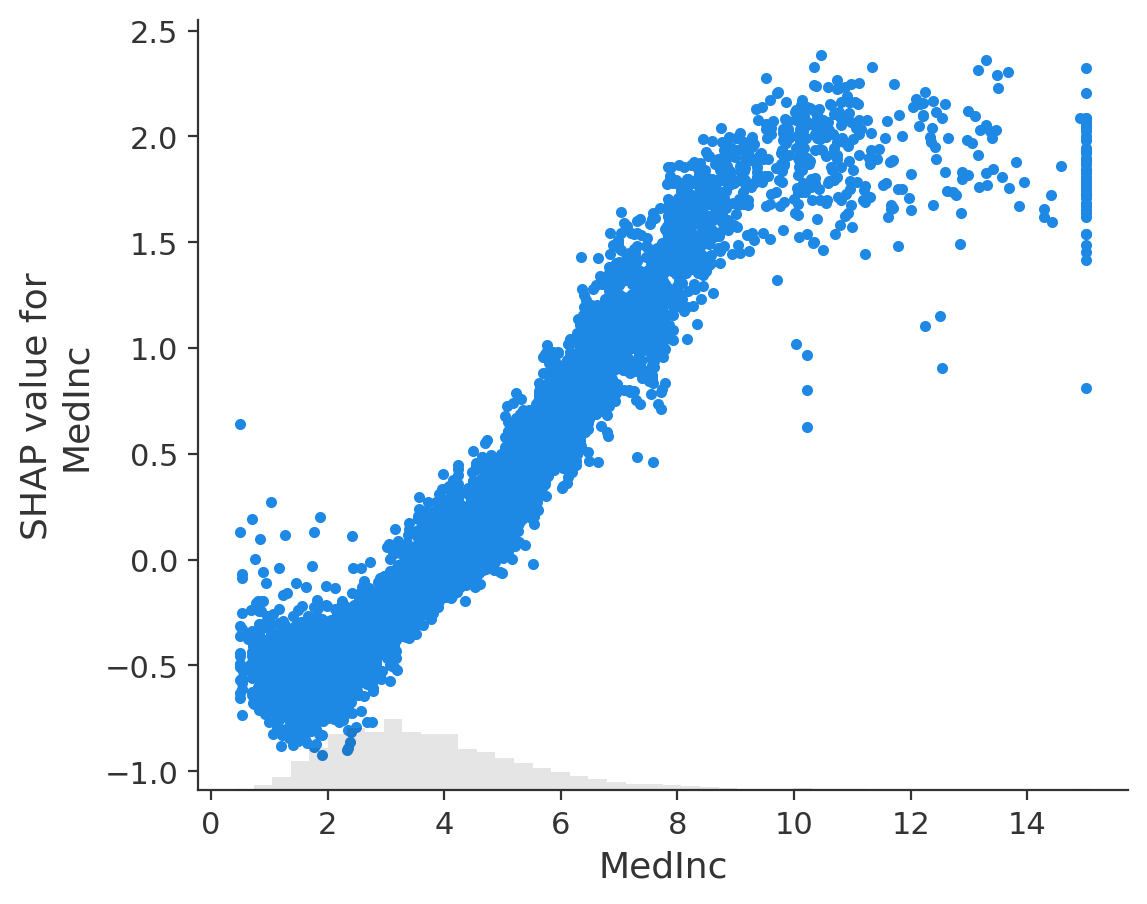

In [19]:
shap.plots.scatter(shap_values[:, "MedInc"])

Ostatnią grupę wykresów pełnią wykresy podsumowujące wszystkie predykcje do tego służą wykresy `beeswarm` i `bar`

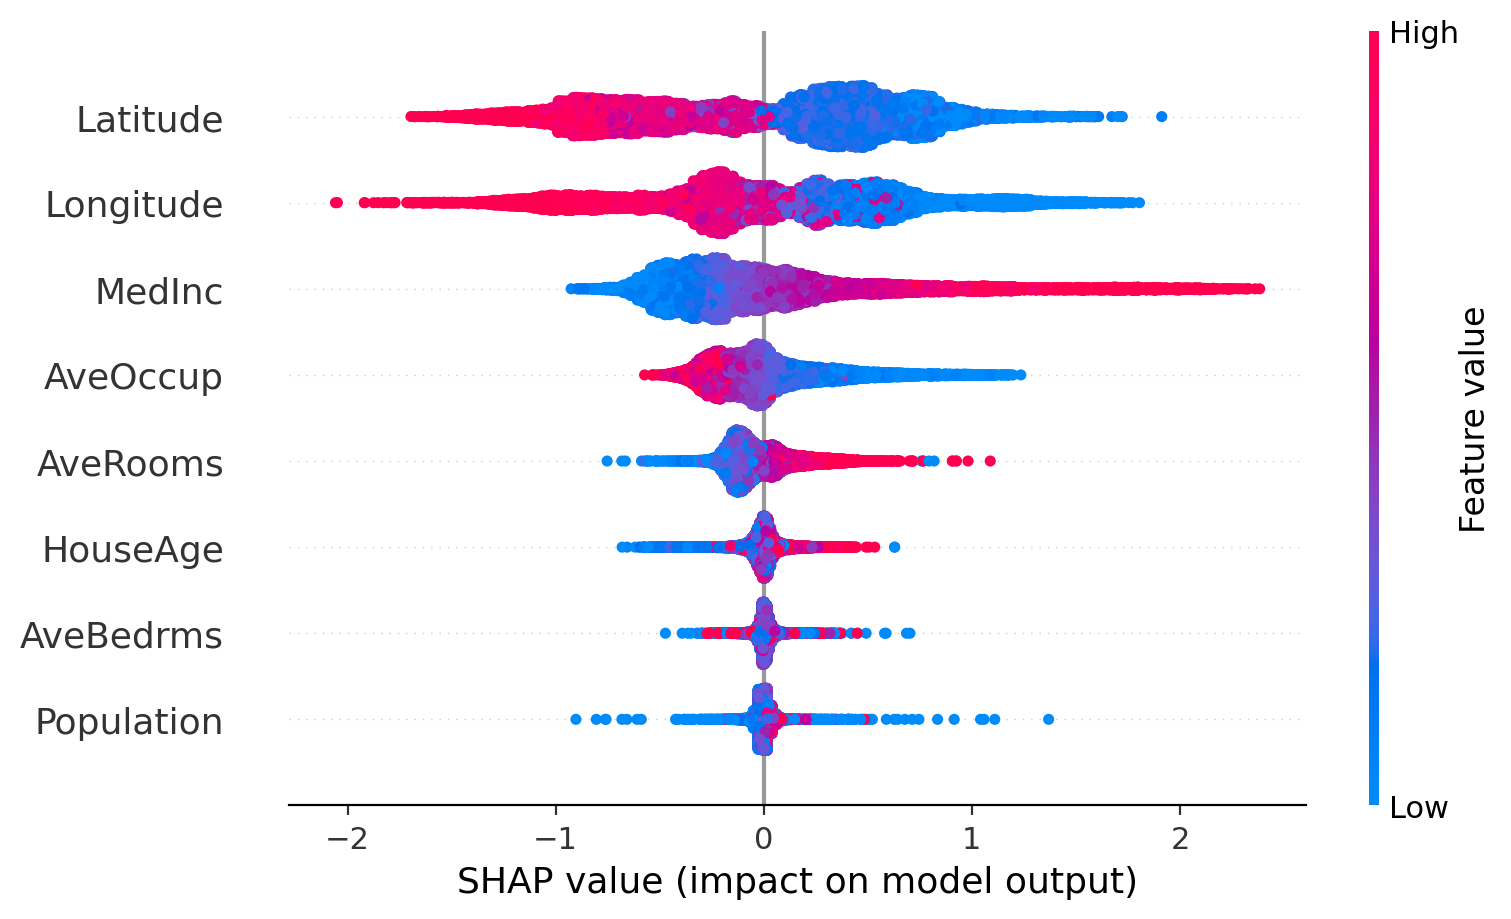

In [20]:
shap.summary_plot(shap_values)

Na podstawie analizy możemy zinterpretować zależności badanych cech na wysokość predykcji.

```{seealso}
Polecam [bardzo fajny post](https://miroslawmamczur.pl/wartosc-shapleya-interpretacja-modeli-blackbox/) na temat shapa.
```

```{seealso}
Istnieją również inne metody wyjaśnialności modeli - np. [ELI5](https://eli5.readthedocs.io/en/latest/), [LIME](https://github.com/marcotcr/lime), [DALEX](https://github.com/ModelOriented/DALEX)
```

## AutoML

Ciekawym rozwiązaniem jest też AutoML, automatycznie dobierajacy model i parametry do zadanego problemu - np. rozwiązanie [H2O AutoML](https://www.h2o.ai/products/h2o-automl/)

